# Review: Reservoir Simulation for Constant Demand

In the beginning of this notebook, we will reprise what we did in unit 2-1, where a reservoir meets all its demands and spills when its project storage would overtop. I've arranged all the preliminary imports and functions at the top of the notebook, and then all of the steps to actually carry out the analysis with data come at the end.

Afterwards, we will build new functions that calculate the elevation of water in the reservoir, and use that elevation to make more nuanced decisions about how to operate the reservoir.

**Note**: this file should reflect the correction for copying numpy arrays, but please refer to the 1/30 code for the latest version!

In [ ]:
import pandas as pd #for dataframes and data processing
import numpy as np #for numerical computation
import sys #system functions

In [ ]:
def convert_cms_to_mcm(val):
  # converts from cubic meters per second to millions of cubic meters
  # (assumes a length of time equal to one day)
  return val*24*60*60/1e6

In [ ]:
def transition_from_to_full(sto, cap):

  # input: 
  # sto -- numpy array of the storage record
  # cap -- the capacity that is considered full

  # return:
  # a dataframe where each event is a row

  # store times in which storage is below capacity
  # (adding 0 at beginning and end helps with beginning and end conditions)
  is_less_than_full = np.append([0], sto < cap)
  is_less_than_full = np.append(is_less_than_full, [0])

  # track timesteps where the previous timestep was full
  # store as 1 and 0 instead of true and false (astype(int))
  change_from_full = np.diff(is_less_than_full.astype(int))

  # change_from_full will show a 1 when the series goes
  # from full to less than full, and a -1 when the series
  # goes from being less than full to full again. This is the
  # "event" we care about.

  # below, we keep track of all of the entries in which
  # we find a 1 (signalling that draining is beginning)
  # and a -1 (signalling that the reservoir is full again)
  start = np.flatnonzero(change_from_full == 1)
  end = np.flatnonzero(change_from_full == -1)
  length = end - start

  # the returned dataframe tells you index values where the events
  # started, ended, and the length in timesteps of each event
  df = pd.DataFrame()
  df['Start'] = start
  df['End'] = end
  df['Length'] = length

  return df

In [ ]:
def res_sim_basic(df, initial_storage, storage_capacity):

  # adapted from S. Galelli MATLAB reservoir simulation code

  # input:
  # df -- data frame with Inflow and Demand for the entire timeseries,
  # in volume units.
  #
  # initial_storage -- initial storage in volume units
  #
  # storage_capacity -- storage capacity in volume units (any storage
  # greater than this volume will spill)
  
  # output: 
  # a copy of the dataframe that adds columns:
  # Storage, Delivery, Spill, Outflow

  # Assumptions: assume reservoir can release all storage to meet demand
  # spill occurs if storage exceeds capacity
  # no capacity constraints for releasing spill

  # CORRECTION: 1/30: added copy=True
  inflow = df['Inflow'].to_numpy(copy=True)
  demand = df['Demand'].to_numpy(copy=True)

  N = len(inflow)

  # create new arrays to store variables, each the same length
  storage = np.zeros(N)
  delivery = np.zeros(N)
  spill = np.zeros(N)
  outflow = np.zeros(N)

  storage[0] = initial_storage

  for i in range(N):
    # assume the inflow and the current storage volume at the current timestep
    # is all available to meet demand
    available_water = inflow[i] + storage[i]

    if available_water > demand[i]:
      # deliver all the water that is requested
      delivery[i] = demand[i]
    else:
      # only deliver what you have
      delivery[i] = available_water

    # if all we do is allow inflow to come in, and release delivery[i],
    # see how much storage there will be left
    trial_storage = storage[i] + inflow[i] - delivery[i]

    # check if trial_storage exceeds capacity, if so, spill the
    # excess water
    if trial_storage > storage_capacity:
      spill[i] = trial_storage - storage_capacity
      if i < N-1: 
        storage[i+1] = storage_capacity
    else:
      spill[i] = 0
      if i < N-1:
        storage[i+1] = trial_storage
    
    # note: in the above, we only store the 'next storage value' up to
    # N-1, because of zero indexing. The array only has N members wh
    
    # store outflow as the sum of both spill and delivery
    outflow[i] = spill[i] + delivery[i]

  # before exiting, save the data into the dataframe, which is the only thing
  # returned
  df['Storage'] = storage
  df['Delivery'] = delivery
  df['Spill'] = spill
  df['Outflow'] = outflow

  return df

The code:
```
if i < N-1:
```
comes from zero indexing. A numpy array that is length N has indices that go from 0 to N-1. This code is saving the next timestep's storage value, so if it tried to write to ```storage[N]``` that would be one longer than the length of the numpy array.



**Carrying Out the Basic Reservoir Simulation**

Now that all of our 'helper functions' exist, we get our data ready and use the functions to carry out our analysis.

You'll notice that variable names that exist inside of functions look different than the variable names "outside" the function. That's on purpose! We wrote our functions to be as generic as possible. But when we are creating variables to store data, we may want to be more specific. That's why I'm calling the dataframe ```basic_df``` below, because I don't want to get it confused with the analysis we're doing later.

In [ ]:
# before running this, make sure the Excel file is in your Colab filesystem
basic_df = pd.read_excel('Des_Moines_River_flow.xls', index_col=0)

# CORRECTION: 1/30: added copy=True
basic_df['Inflow'] = convert_cms_to_mcm(basic_df['Average flow (m3/s)'].to_numpy(copy=True))
basic_df['Demand'] = 2.5

In [ ]:
# perform the basic simulation with an initial storage of 750, and a capcity of 750
basic_df = res_sim_basic(basic_df, 750, 750)

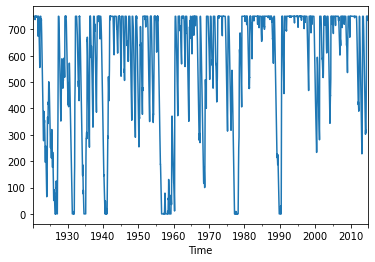

In [ ]:
# plot the storage
basic_df['Storage'].plot()

Now ```basic_df``` exists and has the the results columns!

Our final code processes the data and performs the yield analysis from the end of the 2-1 lecture.

In [ ]:
# events_df will track all the 'events' in which the storage
# value went from full to something less than full
# correction 1/30: added copy=True
events_df = transition_from_to_full(basic_df["Storage"].to_numpy(copy=True), 750)

In [ ]:
# correction 1/30: added copy=True

# we call the "critical period" the time period that was the longest
# to go from the reservoir being completely full, to empty, to full again
# (i.e., the longest "length" in all the events we just found)
crit_period_length = np.max(events_df["Length"].to_numpy(copy=True))

# of all the events we stored, which one constitutes the longest one?
crit_period_eventindex = np.argmax(events_df["Length"].to_numpy(copy=True))

In [ ]:
# iloc allows us to pull out a row of a dataframe, with the index we just found.
# it's a convenient way to display the information we need -- the start day, the end
# day, and the length of the event.
events_df.iloc[crit_period_eventindex]

Start      792
End       2601
Length    1809
Name: 7, dtype: int64

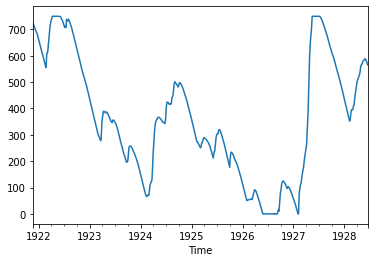

In [ ]:
# Store a new daily dataframe, only keeping the rows
# in the vicinity of the worst event
worst_event_df = basic_df.iloc[600:3000]

worst_event_df["Storage"].plot()

# Rating Curve: Lookup table of elevation and storage volume

In real-life systems, reservoirs are often managed using the **elevation** of water at any time, rather than the storage volume, because the elevation is much more observable than elevation (you can simply measure the depth of the water at any time). Rule curves, then, are also expressed as a function of elevation.

Our original code already had a very minor type of elevation-related decision rule: the 'top' of the reservoir that dicated spill. In this module, we will develop a rating curve for a reservoir (i.e., elevation as a function of storage or vice versa), and then build a basic rule curve that uses elevations to trigger actions in the reservoir.

This analysis will still have several caveats:


*   Rating curves generally have more variables, including:
  * **Outflow** -- if the reservoir is not managed, the elevation of water directly indicates outflow. 
  * **Surface Area** -- evaporation calculations are often some function of the surface area of the reservoir. Reservoirs often exhibit a triangular or bowl shape, where the surface area is smaller at the bottom of the reservoir, and larger at the top.
  * **Depth** rather than elevation -- to convert, simply subtract a baseline elevation from your elevation column and you can call it depth.
*   Similar to a spreadsheet, simply **change the interpolation columns** if you need to use another one of these variables (i.e., finding storage as a function of depth instead of elevation)
*   We are not concerned at this point with physical outflow characteristics of the reservoir. We will still just work with volumes, assuming that **if we desire to deliver a certain volume of water, we can**. Later in the class you will see basic optimization models that operate similarly. Any kind of physical flow requirements are often added in as constraints or extra equations, but I think it's fair to treat them as a secondary concern right now.

First, we will create a dataframe that has the rating curve information. Then two functions will demonstrate how to interpolate between the columns. [Check out this primer on how to create data frames](https://www.geeksforgeeks.org/different-ways-to-create-pandas-dataframe/) if the construction below confuses you.



In [ ]:
from scipy import interpolate

def elev_to_sto(elev, rating):
  f = interpolate.interp1d(rating['Elevation'].to_numpy(),
                           rating['Storage'].to_numpy(),
                           fill_value="extrapolate")
  sto = float(f(elev))
  return sto

def sto_to_elev(sto, rating):
  f = interpolate.interp1d(rating['Storage'].to_numpy(),
                           rating['Elevation'].to_numpy(), 
                           fill_value="extrapolate")
  elev = float(f(sto))
  return elev

# coordinate pairs: elevation (in meters)  and
# storage (in millions of cubic meters)
des_moines_res_data = [[224.0, 0.0], [250.0, 600.0], [274.3, 750.0]]
# convert to dataframe
des_moines_rating = pd.DataFrame(des_moines_res_data, columns=['Elevation', 'Storage'])

In the 'helper functions', the local variables have generic names. For example, the function ```elev_to_sto``` takes a particular ```elev``` elevation as an input, along with the entire rating curve, ```rating```. Then it returns the ```sto``` associated with the given elevation.

But when we actually create the particular rating curve for our application, we call it something more specific... in fact, we are using the name of the reservoir within the variable name. You'll also see that sometimes I add ```_df``` to the variable name, and sometimes I don't. The variable names are totally up to the programmer! When I'm teaching, I like to signal which datatype I'm using, but, unfortunately, there's nothing stopping you from having a variable name that suggests one datatype and then your variable actually has another datatype 👀. Frustrating!

**Using the rating curve**

We will now display the rating curve, and use it to find some desired values.

In [ ]:
des_moines_rating

,Elevation,Storage
0,224.0,0.0
1,250.0,600.0
2,274.3,750.0


In [ ]:
my_elevation = 225.0
my_storage = elev_to_sto(my_elevation, des_moines_rating)

print("elevation of ", my_elevation, " yields storage of ", my_storage)

elevation of  225.0  yields storage of  23.076923076923077


The version of the interpolation function I'm using allows there to be extrapolation of the data. This is important, since similar to the ```res_sim_basic``` code above, there will be times when we will be calculating storage values that are above capacity (when figuring out spill). 

The below test shows off some of the mechanisms we'll use in our new reservoir operations code.

In [ ]:
too_high_elev = 277.0
too_high_storage = elev_to_sto(too_high_elev, des_moines_rating)

if too_high_storage > des_moines_rating["Storage"].max():
  print("Warning! Storage = ", too_high_storage, 
        " is greater than the capacity, which is ", 
        des_moines_rating["Storage"].max(), " we will spill: ",
        too_high_storage-des_moines_rating["Storage"].max())
else:
  print("The storage is less than the capacity!")

Warning! Storage =  766.6666666666666  is greater than the capacity, which is  750.0  we will spill:  16.66666666666663


To test the other part of the if-else statement:

In [ ]:
test_elev = 230.0
test_storage = elev_to_sto(test_elev, des_moines_rating)

if test_storage > des_moines_rating["Storage"].max():
  print("Warning! Storage = ", test_storage, 
        " is greater than the capacity, which is ", 
        des_moines_rating["Storage"].max(), " we will spill: ",
        test_storage-des_moines_rating["Storage"].max())
else:
  print("The storage is less than the capacity!")

The storage is less than the capacity!


The flow of the above code:

*   Assign ```test_elev```
*   Find ```test_storage``` by calling our helper function
*   Enter the if statement, and test the first condition
*   The condition was false, thus we only executed what was in the ```else:``` condition.



# Adding a basic rule curve to our reservoir operations

Now that we have our rating curve, we can add in management rules that use elevations as triggers. A [Python dictionary](https://www.geeksforgeeks.org/python-dictionary/) is a nice data structure for this, since we would like these elevations to be accessed by easy to remember names, called 'keys'. To input a dictionary, we simply type pairs of the keys and then the values. Notice we can embed different commands into our creation of the dictionary, where the bottom and top of the reservoir are the minimum and maximum elevations in our rating curve, respectively.

In [ ]:
des_moines_static_triggers = {'Bottom of Reservoir': np.min(des_moines_rating['Elevation'].to_numpy()),
                   'Top of Dead Storage': 226.0, 
                   'Top of Conservation': 260.0, 
                   'Top of Reservoir': np.max(des_moines_rating['Elevation'].to_numpy())
                   }

In [ ]:
des_moines_static_triggers

{'Bottom of Reservoir': 224.0,
 'Top of Dead Storage': 226.0,
 'Top of Conservation': 260.0,
 'Top of Reservoir': 274.3}

The reservoir management rules for the new simulation are as follows:

*   Deliver water to meet demand, subject to:
  *   Between bottom of reservoir and top of dead storage, you cannot release water
  *   Between top of dead storage and conservation, you can release water
  *   Between top of conservation and top of reservoir, release additional water for flood control purposes

Before continuing, think about how these changes will affect the reservoir's ability to deliver water.

Our new reservoir operation algorithm has a similar output structure to ```res_sim_basic```, so it could be possible to compare and contrast how the two schemes compare with one another! Here, we need more inputs because this scheme is more complicated.



*   In the input list, the dataframe is denoted ```timeseries``` because we **will now be working with multiple data frames**. In the basic simulation, we only had a timeseries dataframe and we could just call it ```df```. Now, we also have the rating curve.
*   On the one hand, using dataframes as inputs and outputs to a function is convenient, because everything is well organized. But, it also means that **you have to be consistent with your column names**. So if you had a different set of triggers with different names, you'd have to be careful to specify this in the code too.
*   Just like in real-world systems, we're going to be bouncing back and forth between storage and elevation, since certain rules are written relative to storage, and others relative to elevation. (You will do similar manipulations in RiverWare)
*   You'll see **the operations change depending on elevation**! 
   *  At flood control and emergency operations tiers, we use the max function to decide releases. This is because our calculation isn't perfect; for large deliveries, it may turn out that the trial storage doesn't exceed the tier level, and thus we wouldn't want to spill or release too much.
   *  In general, this is why we use more sophisticated tools like RiverWare to solve these problems! The ideal solution to the problem would require an iterative solution, as we'll see later.



In [ ]:
def res_sim_static_triggers(timeseries, rating, triggers, initial_elev):

  # inputs: 
  #
  # timeseries -- inflow and demand for all time (volume units)
  #
  # rating -- rating curve of elevation and storage (length units)
  #
  # triggers -- rule curve dictionary (elevation triggers, same units/
  # datum as rating
  #
  # initial_elev -- initial elevation in same units/datum as rating
  #
  # output: return a copy of timeseries with new columns:
  # Storage, Elevation, Delivery, Flood Release, Spill, Outflow

  # process timeseries
  # corrrection 1/30: added copy=True
  inflow = timeseries['Inflow'].to_numpy(copy=True)
  demand = timeseries['Demand'].to_numpy(copy=True)

  N = len(inflow)

  # create new arrays to store variables, each the same length
  storage = np.zeros(N)
  elevation = np.zeros(N)
  delivery = np.zeros(N)
  flood_release = np.zeros(N)
  spill = np.zeros(N)
  outflow = np.zeros(N)

  elevation[0] = initial_elev
  storage[0] = elev_to_sto(elevation[0], rating)

  for i in range(N):
   
    if storage[i] + inflow[i] > demand[i]:
      # assume that you'll eventually deliver all demand
      trial_storage = storage[i] + inflow[i] - demand[i]
    else:
      # you probably won't deliver all demand. here we just check
      # the current storage+inflow to see where it falls in these triggers
      # (this may not be a perfect assumption)
      trial_storage = storage[i] + inflow[i]
   
    trial_elevation = sto_to_elev(trial_storage, rating)

    # set delivery, flood_release, and spill based on the relationship between
    # trial_elevation and the triggers
    if trial_elevation >= triggers['Bottom of Reservoir'] and trial_elevation < triggers['Top of Dead Storage']:
      # your calculated storage puts you into dead storage, and thus you cannot release.
      delivery[i] = 0.0
      flood_release[i] = 0.0
      spill[i] = 0.0
    elif trial_elevation <= triggers['Top of Conservation']:
      # your calculated storage means you're in conservation. Release,
      # and you won't need to do flood releases or spill
      delivery[i] = min(demand[i], storage[i] + inflow[i])
      flood_release[i] = 0.0
      spill[i] = 0.0
    elif trial_elevation <= triggers['Top of Reservoir']:
      # your calculated storage means you're in flood control. Release for demand,
      # but also you may need to release for flood control purposes
      delivery[i] = min(demand[i], storage[i] + inflow[i])
      flood_release[i] = max(storage[i] + inflow[i] - delivery[i] - elev_to_sto(triggers['Top of Conservation'], rating), 
                             0.0)
      spill[i] = 0.0
    else:
      # your calculated storage puts you above the safe release zone. Release for
      # demand and flood control, but there is also spill
      delivery[i] = min(demand[i], storage[i] + inflow[i])
      flood_release[i] = max(storage[i] + inflow[i] - delivery[i] - elev_to_sto(triggers['Top of Conservation'], rating), 
                             0.0)
      spill[i] = max(storage[i] + inflow[i] - delivery[i] - flood_release[i] - 
                     elev_to_sto(triggers['Top of Reservoir'], rating), 
                     0.0)
    
    # get ready for next timestep
    outflow[i] = delivery[i] + flood_release[i] + spill[i]
    if i < N-1:
      storage[i+1] = storage[i] + inflow[i] - outflow[i]
      elevation[i+1] = sto_to_elev(storage[i+1], rating)

  # before exiting, save the data into the dataframe
  timeseries['Storage'] = storage
  timeseries['Elevation'] = elevation
  timeseries['Delivery'] = delivery
  timeseries['Flood Release'] = flood_release
  timeseries['Spill'] = spill
  timeseries['Outflow'] = outflow

  return timeseries

**Implementation below**

One thing to note is that creating the triggers is more of an 'implementation' step, so ideally we would write up the helper functions first, and then assign the triggers here. Such is the trouble with putting everything in notebooks! 😆

*Speaking of that, it isn't strictly necessary to read the Excel file in again. I just wanted to make this example stand on its own. If you were comparing reservoir operation schemes, you could save everything in a master dataframe and re-name the columns. We can demonstrate that technique later.*

In [ ]:
# make sure the Excel file is uploaded to your directory
with_triggers_df = pd.read_excel('Des_Moines_River_flow.xls', index_col=0)

# process the data, populating columns in the data frame for inflow and demand
# (these variables will have units of millions of cubic meters)
# correction 1/30: added copy=True
with_triggers_df['Inflow'] = convert_cms_to_mcm(with_triggers_df['Average flow (m3/s)'].to_numpy(copy=True))
with_triggers_df['Demand'] = 5.0

In [ ]:
with_triggers_df = res_sim_static_triggers(with_triggers_df, des_moines_rating, des_moines_static_triggers, 224)

In [ ]:
with_triggers_df

,Average flow (m3/s),Inflow,Demand,Storage,Elevation,Delivery,Flood Release,Spill,Outflow
Time,,,,,,,,,
1920-04-01,117.600,10.160640,5.0,0.000000,224.000000,0.0,0.0,0.0,0.0
1920-04-02,117.600,10.160640,5.0,10.160640,224.440294,0.0,0.0,0.0,0.0
1920-04-03,112.000,9.676800,5.0,20.321280,224.880589,0.0,0.0,0.0,0.0
1920-04-04,100.800,8.709120,5.0,29.998080,225.299917,0.0,0.0,0.0,0.0
1920-04-05,98.000,8.467200,5.0,38.707200,225.677312,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2014-11-12,35.396,3.058214,5.0,645.806705,257.420686,5.0,0.0,0.0,5.0
2014-11-13,32.281,2.789078,5.0,643.864920,257.106117,5.0,0.0,0.0,5.0
2014-11-14,28.600,2.471040,5.0,641.653998,256.747948,5.0,0.0,0.0,5.0


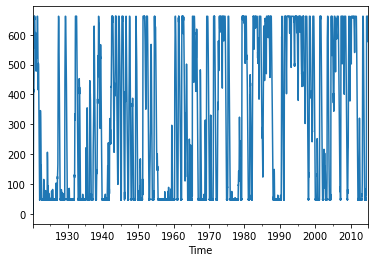

In [ ]:
with_triggers_df['Storage'].plot()